<a href="https://colab.research.google.com/github/bayashi-cl/statistical-learning/blob/working/note/03_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols

sns.set()
ad = pd.read_csv("https://www.statlearning.com/s/Advertising.csv", index_col=0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 3 線形回帰

[スライド](https://web.stanford.edu/~hastie/ISLR2/Slides/Ch3_Linear_Regression.pdf)

線形回帰の特徴
* 教師あり学習
* シンプル
* 定量的な予測に強い

今後に出てくる学習の手法は線形回帰を発展させたものが多い。

`Advertising`（スライドp）のデータからマーケティングプランを提案するにはどのような情報が必要だろうか。

以下のような問題について考える。

1. そもそも広告費と売上の間に関係性はあるか。
1. その関係はどれくらい強いのか。
1. どのメディアがどれだけ売上に貢献しているか。
1. 売上の予測はどれくらい正確か。
1. 関係性は線形か。
1. メディア間の相乗効果は存在するのか。



## 3.1 単回帰

単回帰では $Y$ を目的変数、 $X$ を説明変数として、

$$Y \approx \beta_0 + \beta_1X$$

のようなモデルを考える。例えば`sales`と`TV`の関係なら、

$$\textrm{sales} \approx \beta_0 + \beta_1 \times \textrm{TV}$$

として $\hat{\beta}$ を求める。


### 3.1.1 パラメータの推定

まずは**最小二乗法**で考える（他の考え方は6章で）。

$\hat{y}_i = \hat{\beta_0}+\hat{\beta_1}x_i$ を $i$ 番目のデータに対する推定値として残差を $e_i = y_i - \hat{y_i}$ とする。

ここで**残差平方和**(*residual sum of squares (RSS)*)を

$$\textrm{RSS} = e_1^2+ \cdots + e_n^2$$

と定義してこれを最小化すると、

$$
\begin{aligned}
  \hat{\beta_1} &= \frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}\\
  \hat{\beta_0} &= \bar{y}-\hat{\beta_1}\bar{x}
\end{aligned}
$$

となる。
実際に計算をすると



In [73]:
X = ad['TV'].to_numpy()
Y = ad['sales'].to_numpy()
x_bar = X.mean()
y_bar = Y.mean()

numerator = 0.0
denominator = 0.0

for xi, yi in zip(X, Y):
  numerator += (xi - x_bar) * (yi - y_bar)
  denominator += (xi - x_bar)**2

beta_hat_1 = numerator / denominator
beta_hat_0 = y_bar - beta_hat_1 * x_bar

min_rss = 0.0
for xi, yi in zip(X, Y):
  yi_hat = beta_hat_0 + beta_hat_1 * xi
  min_rss += (yi - yi_hat)**2


print(f"sales   = {beta_hat_0:.5f} + {beta_hat_1:.5f} * TV")
print(f"min RSS = {min_rss:.5f}")

sales   = 7.03259 + 0.04754 * TV
min RSS = 2102.53058


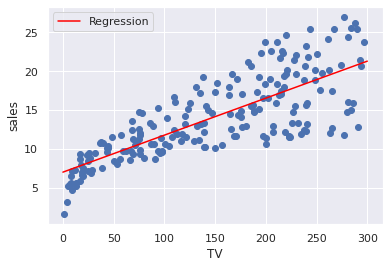

In [59]:
fig, ax = plt.subplots()
ax.scatter(ad['TV'], ad['sales'])
reg_x = np.linspace(0, 300, 100)
reg_y = beta_hat_0 + beta_hat_1 * reg_x
ax.plot(reg_x, reg_y, color="red", label="Regression")
ax.set(xlabel="TV", ylabel="sales")
ax.legend()
plt.show()

In [39]:
sz = 50
b0_ = np.linspace(beta_hat_0 - 2, beta_hat_0 + 2, sz)
b1_ = np.linspace(beta_hat_1 - 0.02, beta_hat_1 + 0.02, sz)
b0, b1 = np.meshgrid(b0_, b1_, indexing='xy')
rss = np.zeros((sz, sz))

for (i, j), _ in np.ndenumerate(rss):
    rss[i, j] = ((Y - (b0[i, j] + X * b1[i, j]))**2).sum() / 1000

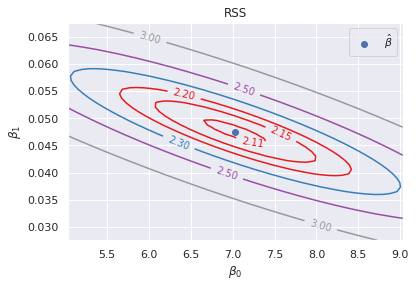

In [67]:
fig, ax = plt.subplots()
cont = ax.contour(b0, b1, rss, cmap=plt.cm.Set1, levels=[2.11, 2.15, 2.2, 2.3, 2.5, 3])
cont.clabel(fmt='%1.2f', fontsize=10)
ax.scatter(beta_hat_0, beta_hat_1, label=r"$\hat{\beta}$")
ax.set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="RSS")
ax.legend()
plt.show()

となる。（教科書の数値と一致）


### 3.1.2 推定値の制度の評価

母集団に対してこのモデルをあてはめると $X$ と $Y$の関係は

$Y = \beta_0 + \beta_1X + \epsilon$

この式は**母集団回帰線** *(population regression line)* と呼ばれ、誤差項 $\epsilon$ はこのモデルで見逃している要素（他の変数や観測誤差など）を表す。

最小二乗法による推定は母集団回帰線に一致するとは限らないが、不偏性があるので観測を繰り返せば正確になっていく。

$\hat{\beta_0}$ と $\hat{\beta_1}$ の分散はそれぞれ、

$$
\textrm{SE}(\hat{\beta_0})^2 = \sigma^2\left[ \frac{1}{n}+\frac{\bar{x}^2}{\sum_{i=1}^n(x_i-\bar{x})^2}\right]
$$

$$
\textrm{SE}(\hat{\beta_1})^2 = \frac{\sigma^2}{\sum_{i=1}^n(x_i-\bar{x})^2}
$$

厳密には誤差 $\epsilon$ が共通の分散を持ち独立である必要があるが、そうでなくても近似として有効である。

$x$がバラけていたほうが$\hat{\beta_1}$ の分散が小さくなり、少ないデータで正確な推定ができるようになる。

$\sigma^2$ は未知だが、データから推定することができ、その推定量 $\textrm{RSE} = \sqrt{\textrm{RSS}/(n-2)}$ を**残差標準偏差** *(residual standard error)* と呼ぶ 

標準偏差は信頼区間の推定にも使うことができ、その95%信頼区間はそれぞれ

$$\hat{\beta_1} \pm 2 \cdot \textrm{SE}(\hat{\beta_1})$$
$$\hat{\beta_0} \pm 2 \cdot \textrm{SE}(\hat{\beta_0})$$

で構成される。


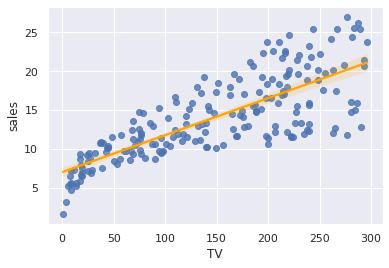

In [72]:
sns.regplot(data=ad, x="TV", y="sales", line_kws={'color': 'orange'})
plt.show()

$X$ と $Y$ に関係性があるかは検定により確認できる。

$$
H_0:\beta_1 = 0\\
H_1:\beta_1 \ne 0
$$

t統計量が標準偏差のばらつきを無視できるほど大きければ帰無仮説をrejectできる。

In [75]:
result = ols(formula='sales ~ TV', data=ad).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sun, 28 Nov 2021   Prob (F-statistic):           1.47e-42
Time:                        14:19:08   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0